# Train neural MCTS

---

Author: S. Menary [sbmenary@gmail.com]

Date  : 2023-01-15, last edit 2023-01-19

Brief : Train a bot neural network by playing games using a previous bot generation (vanilla MCTS if this is the first iteration)

---

## Imports

---

In [1]:
##=====================================##
##  All imports should be placed here  ##
##=====================================##

##  Python core libs
import pickle, sys, time

##  PyPI libs
import numpy as np
from matplotlib import pyplot as plt

##  Local packages
from connect4.utils    import DebugLevel
from connect4.game     import BinaryPlayer, GameBoard, GameResult
from connect4.MCTS     import Node_NeuralMCTS, PolicyStrategy
from connect4.bot      import Bot_NeuralMCTS, Bot_VanillaMCTS
from connect4.parallel import generate_from_processes
from connect4.methods  import get_training_data_from_bot_game


In [2]:
##=====================================##
##  Print version for reproducibility  ##
##=====================================##

print(f"{'Python'    .rjust(12)} version is {sys.version}")
print(f"{'Numpy'     .rjust(12)} version is {np.__version__}")


      Python version is 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
       Numpy version is 1.23.2


---

##  Configure run

---

In [3]:
##============================##
##  Set global config values  ##
##============================##

model_idx      = 7
old_model_name = f"../models/.neural_model_v{model_idx-1}.h5"
new_model_name = f"../models/.neural_model_v{model_idx}.h5"

load_data  = False
save_data  = not load_data
data_fname = f"../data/.training_data_v{model_idx}.pickle"

tune_previous_model = True       ## whether to load+tune previous model or create+train new one

num_processes      = 7
num_games_per_proc = 1000
base_seed          = int(time.time())
duration           = .5
discount           = 0.99
monitor_frequency  = 3
num_random_moves   = 2
policy_strategy    = PolicyStrategy.NOISY_POSTERIOR_POLICY

print(f"Using old model: {old_model_name}")
print(f"Using new model: {new_model_name}")
print(f"Using data file: {data_fname}")


Using old model: ../models/.neural_model_v5.h5
Using new model: ../models/.neural_model_v6.h5
Using data file: ../data/.training_data_v6.pickle


---

## Data generation and preprocessing

---

In [4]:
##========================================================================##
##  Define method allowing data to be generated in parallel subprocesses  ##
##========================================================================##

##  N.B. connect4.neural import must be performed inside the method executed inside each child process
##  to avoid a deadlock caused when a tf session has already been created in __main__

def generate_datapoints_process(proc_idx, num_games, out_queue, func_args) :
    from connect4.neural import load_model
    model_name, duration, discount, num_random_moves, policy_strategy, base_seed = func_args
    np.random.seed(base_seed+proc_idx)
    model = load_model(model_name) if len(model_name) > 0 else None
    for game_idx in range(num_games) :
        _ = get_training_data_from_bot_game(model, duration, discount, num_random_moves)
        out_queue.put(_)


In [5]:
##======================##
##  Generate/load data  ##
##======================##

if load_data :
    ##  Load data from pickle file
    print(f"Loading data from file: {data_fname}")
    loaded   = pickle.load(open(data_fname, "rb"))
    model_in = loaded["model_in"]
    model_p  = loaded["model_p" ]
    model_v  = loaded["model_v" ]
else :
    ##  Run subprocesses to generate new data
    print(f"Generating {num_processes*num_games_per_proc} datapoints with base seed {base_seed}")
    print(f"Using duration = {duration:.3f}\nUsing discount = {discount:.3f}")
    results = generate_from_processes(
        func                 = generate_datapoints_process, 
        func_args            = [old_model_name, duration, discount, num_random_moves, policy_strategy, base_seed],
        num_proc             = num_processes, 
        num_results_per_proc = num_games_per_proc, 
        mon_freq             = monitor_frequency)
                              
    ##  Retrieve training data from worker thread
    model_in = np.concatenate([r[0] for r in results])
    model_p  = np.concatenate([r[1] for r in results])
    model_v  = np.concatenate([r[2] for r in results])
    

Generating 2100 datapoints with base seed 1674161700
Using duration = 3.000
Using discount = 0.990
Generated 2100 / 2100 results [t=25495.39s]
Generation complete [t=25495.40s] [n=2100]


In [6]:
##=============##
##  Save data  ##
##=============##

if save_data :
    print(f"Saving data to file: {data_fname}")
    to_save = {"model_in":model_in, "model_p":model_p, "model_v":model_v, 
               "base_seed":base_seed, "duration":duration, "discount":discount}
    pickle.dump(to_save, open(data_fname, "wb"))
else :
    print("Not saving data because it was loaded from file")
    

Saving data to file: ../data/.training_data_v6.pickle


In [7]:
##================================##
##  Report on the data generated  ##
##================================##

print(f"model_in with shape: {model_in.shape}")
print(f"model_p  with shape: {model_p .shape}")
print(f"model_v  with shape: {model_v .shape}")

model_in with shape: (56853, 7, 6, 1)
model_p  with shape: (56853, 7)
model_v  with shape: (56853, 1)


In [8]:
##===================================##
##  Data Augmentation and splitting  ##
##===================================##

##  Randomly flip board and posterior in x-direction to created augmented dataset reflecting game symmetry
for idx in range(len(model_in)) :
    if np.random.choice([True, False]) : continue
    model_in[idx] = np.flip(model_in[idx], axis=0)
    model_p [idx] = np.flip(model_p [idx], axis=0)

##  Shuffle data
indices = np.arange(len(model_in))
np.random.shuffle(indices)
model_in, model_p, model_v = model_in[indices], model_p [indices], model_v [indices]

##  Split data into train and val sets
num_datapoints = len(model_in)
split_idx = int(0.7*num_datapoints)

train_model_in = model_in[:split_idx]
train_model_p  = model_p [:split_idx]
train_model_v  = model_v [:split_idx]

val_model_in = model_in[split_idx:]
val_model_p  = model_p [split_idx:]
val_model_v  = model_v [split_idx:]

print(f"Created training set of size {len(train_model_v)}")
print(f"Created validation set of size {len(val_model_v)}")


Created training set of size 39797
Created validation set of size 17056


---

## Model training

---

In [9]:
##=========================##
##  Create/load the model  ##
##=========================##

##  Must import neural module here because it uses tensorflow, which breaks the subprocessing if done above
from connect4.neural import create_model, load_model

##  Load or create model
if tune_previous_model :
    print("Loading model from previous iteration")
    new_model = load_model(old_model_name)
else :
    print("Creating new model")
    new_model = create_model(name=new_model_name, num_conv_blocks=4, num_filters=40, num_dense=5, 
                         dense_width=200, batch_norm=True)

##  Print model summary
new_model.summary()


Loading model from previous iteration
Model: "../models/.neural_model_v2.h5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 game_board_input (InputLayer)  [(None, 7, 6, 1)]    0           []                               
                                                                                                  
 conv0_conv2d (Conv2D)          (None, 7, 6, 40)     400         ['game_board_input[0][0]']       
                                                                                                  
 conv0_skipconnect (Concatenate  (None, 7, 6, 41)    0           ['conv0_conv2d[0][0]',           
 )                                                                'game_board_input[0][0]']       
                                                                                                  
 conv0_dropout (Dropout)        

In [10]:
##==================##
##  Model training  ##
##==================##

##  Must import tensorflow modules here, because it breaks the subprocessing if done above
from tensorflow.keras.callbacks import EarlyStopping

##  Train the model
history = new_model.fit(
            model_in, [model_p, model_v], epochs=1000, batch_size=100,
            validation_data=(val_model_in, [val_model_p, val_model_v]),
            callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)])

##  Save the new model
new_model.save(new_model_name)


Epoch 1/1000


2023-01-20 03:59:57.991548: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


569/569 [==============================] - 19s 33ms/step - loss: 2.0440 - policy_loss: 1.4352 - value_loss: 0.6088 - val_loss: 1.8672 - val_policy_loss: 1.3001 - val_value_loss: 0.5671
Epoch 2/1000
569/569 [==============================] - 19s 34ms/step - loss: 1.9195 - policy_loss: 1.3543 - value_loss: 0.5652 - val_loss: 1.7791 - val_policy_loss: 1.2463 - val_value_loss: 0.5327
Epoch 3/1000
569/569 [==============================] - 20s 34ms/step - loss: 1.8520 - policy_loss: 1.3154 - value_loss: 0.5366 - val_loss: 1.6992 - val_policy_loss: 1.2140 - val_value_loss: 0.4852
Epoch 4/1000
569/569 [==============================] - 21s 37ms/step - loss: 1.8032 - policy_loss: 1.2874 - value_loss: 0.5158 - val_loss: 1.6533 - val_policy_loss: 1.1907 - val_value_loss: 0.4626
Epoch 5/1000
569/569 [==============================] - 23s 40ms/step - loss: 1.7645 - policy_loss: 1.2711 - value_loss: 0.4934 - val_loss: 1.5939 - val_policy_loss: 1.1630 - val_value_loss: 0.4309
Epoch 6/1000
569/569 [=

569/569 [==============================] - 23s 40ms/step - loss: 1.2448 - policy_loss: 0.9886 - value_loss: 0.2562 - val_loss: 1.0522 - val_policy_loss: 0.8587 - val_value_loss: 0.1935
Epoch 84/1000
569/569 [==============================] - 24s 41ms/step - loss: 1.2447 - policy_loss: 0.9890 - value_loss: 0.2557 - val_loss: 1.0485 - val_policy_loss: 0.8541 - val_value_loss: 0.1944
Epoch 85/1000
569/569 [==============================] - 24s 41ms/step - loss: 1.2446 - policy_loss: 0.9889 - value_loss: 0.2557 - val_loss: 1.0604 - val_policy_loss: 0.8627 - val_value_loss: 0.1976
Epoch 86/1000
569/569 [==============================] - 22s 39ms/step - loss: 1.2404 - policy_loss: 0.9855 - value_loss: 0.2549 - val_loss: 1.0450 - val_policy_loss: 0.8514 - val_value_loss: 0.1936
Epoch 87/1000
569/569 [==============================] - 23s 40ms/step - loss: 1.2408 - policy_loss: 0.9859 - value_loss: 0.2549 - val_loss: 1.0437 - val_policy_loss: 0.8502 - val_value_loss: 0.1935
Epoch 88/1000
569/5

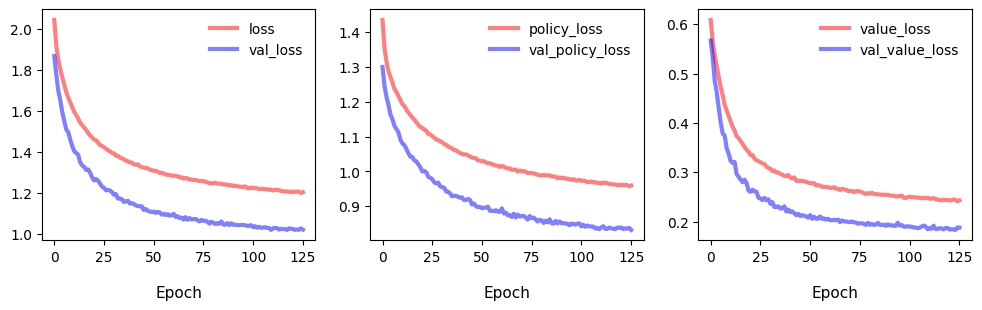

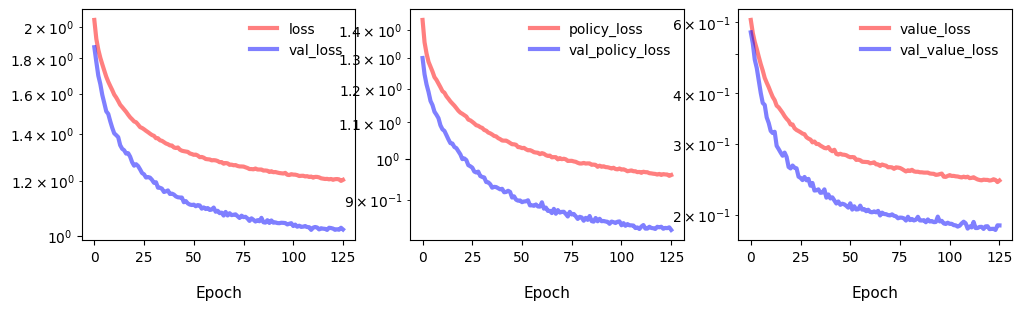

In [11]:
##=================================##
##  Visualise the training curves  ##
##=================================##

##  Define metrics to track
metrics     = ["loss", "policy_loss", "value_loss"]
num_metrics = len(metrics)

##  Plot metrics on both linear and log scales
for do_log in [False, True] :
    
    ##  Create, show and close figure showing training curves (one axis per metric)
    fig      = plt.figure(figsize=(4*num_metrics, 3))
    for ax_idx, metric in enumerate(metrics) :
        val_metric = f"val_{metric}"
        ax  = fig.add_subplot(1, num_metrics, 1+ax_idx)
        ax.plot(history.history[metric], "-", lw=3, c="r", alpha=0.5, label=metric)
        if val_metric in history.history :
            ax.plot(history.history[val_metric], "-", lw=3, c="b", alpha=0.5, label=val_metric)
        ax.legend(loc="upper right", frameon=False, fontsize=10)
        ax.set_xlabel("Epoch", labelpad=15, fontsize=11, ha="center", va="top")
        if do_log : ax.set_yscale("log")
    plt.show(fig)
    plt.close(fig)
    

- Note that we consistently observe val_loss < loss due to either (i) the fact that we are using dropout which affect train but not val metrics, or (ii) train metrics being summed over an epoch but val metrics being calculated only at the end. Suspect (i) because the lag appears to be longer than one epoch.